# Lunar Landing via Images

## Import Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installing Necessary Libraries

In [2]:
!pip install gymnasium
!pip install stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.1.0
    Uninstalling gymnasium-1.1.0:
      Successfully uninstalled gymnasium-1.1.0


## Import Libraries

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Import Gymanasium
import gymnasium
from gymnasium import Env
from gymnasium import spaces

# Import Stable-Baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env

## Sample Environment

In [ ]:
image = Image.open("/content/drive/My Drive/Mask.jpg").convert("L")  # Convert to grayscale
image_data = np.array(image)

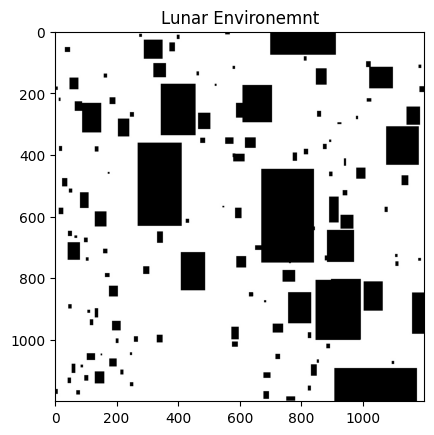

In [ ]:
plt.imshow(image_data, cmap='gray')  # Use cmap='gray' for grayscale images
plt.title("Lunar Environemnt")  # Add a title (optional)
plt.show() # to show the image

## Custom Environment - Lunar Lander

In [4]:
class LunarLandingEnv(Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, image_path):
        super(LunarLandingEnv, self).__init__()

        # Loads the image (grayscale) and converts it into a numpy array
        self.image_path = image_path
        self.image = Image.open(self.image_path).convert("L")
        self.image_data = np.array(self.image) # This array represents the terrain where safe zones (255) and hazard zones (0) are defined

        self.safe_zone_value = 255 # Defines safe zone
        self.hazard_value = 0 # Define hazard zone
        # Convert to list of tuples for faster lookup during step
        self.hazards = [(point[1], point[0]) for point in np.argwhere(self.image_data == self.hazard_value)]

        # Define rewards and penalties with more balanced values
        self.hazard_penalty = -10.0  # Penalty for landing on hazard
        self.proximity_penalty = -0.5  # Penalty for being near hazards
        self.step_penalty = -0.1  # Small penalty for each step to encourage efficiency
        self.landing_reward = 20.0  # Reward for successful landing

        self.action_space = spaces.Discrete(4)  # Action space: Up, Down, Left, Right

        # Observation space: A 5x5 patch of the terrain
        self.patch_size = 5
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.patch_size, self.patch_size), dtype=np.uint8)

        # Defines the maximum x and y coordinates based on image size
        self.max_x = self.image_data.shape[1] - 1
        self.max_y = self.image_data.shape[0] - 1

        # Calculate maximum possible distance for normalization
        self.max_distance = np.sqrt(self.max_x**2 + self.max_y**2)

        # Find start position at the bottom center
        self.start_position = self._find_start_position()
        self.current_position = self.start_position

        # Find ideal landing spots (safe areas with safe neighbors)
        self.landing_spots = self._find_landing_spots()
        if not self.landing_spots:
            # Fallback to any safe position
            safe_positions = [(y, x) for x, y in np.argwhere(self.image_data == self.safe_zone_value)]
            if safe_positions:
                self.landing_spots = [safe_positions[0]]
            else:
                raise ValueError("No safe areas found in the image!")

        # Track number of steps for episode termination
        self.steps = 0
        self.max_steps = 200  # Prevent episodes from running too long

    def _find_start_position(self):
        """Find a starting position at the bottom of the image."""
        height, width = self.image_data.shape
        bottom_row = height - 1
        center_col = width // 2

        # Try bottom center first
        if self.image_data[bottom_row, center_col] == self.safe_zone_value:
            return (center_col, bottom_row)

        # Try to find a safe spot in the bottom row
        safe_pixels = np.argwhere(self.image_data[bottom_row, :] == self.safe_zone_value)
        if len(safe_pixels) > 0:
            closest_safe_pixel = min(safe_pixels, key=lambda p: abs(p[0] - center_col))
            return (closest_safe_pixel[0], bottom_row)

        # If no safe spots in bottom row, find closest safe spot to bottom center
        safe_positions = np.argwhere(self.image_data == self.safe_zone_value)
        if len(safe_positions) > 0:
            # Sort by y-coordinate (descending) and then by distance to center x
            safe_positions = sorted(safe_positions, key=lambda p: (-p[0], abs(p[1] - center_col)))
            return (safe_positions[0][1], safe_positions[0][0])  # x, y format

        raise ValueError("No safe areas found in the image!")

    def _find_landing_spots(self):
        """
        Find landing spots, defined as safe areas where all
        four adjacent neighbors (up, down, left, right) are also safe.
        """
        landing_spots = []
        height, width = self.image_data.shape

        # Define the four adjacent directions
        adjacent_dirs = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # right, down, left, up

        # Iterate through all safe pixels
        for y in range(1, height-1):
            for x in range(1, width-1):
                if self.image_data[y, x] == self.safe_zone_value:
                    # Check all 4 adjacent neighbors
                    is_safe = True
                    for dx, dy in adjacent_dirs:
                        if self.image_data[y+dy, x+dx] != self.safe_zone_value:
                            is_safe = False
                            break

                    if is_safe:
                        landing_spots.append((x, y))

        return landing_spots

    def step(self, action):
        self.steps += 1

        # Variable step size based on height (simulating gravity)
        step_size = max(1, int(5 * (self.current_position[1] / self.max_y)))
        x, y = self.current_position

        # Apply action
        if action == 0:  # Up
            new_pos = (x, max(0, y - step_size))
        elif action == 1:  # Down
            new_pos = (x, min(self.max_y, y + step_size))
        elif action == 2:  # Left
            new_pos = (max(0, x - step_size), y)
        elif action == 3:  # Right
            new_pos = (min(self.max_x, x + step_size), y)
        else:
            new_pos = (x, y)

        # Check if new position is in hazard
        if new_pos not in self.hazards:
            self.current_position = new_pos
        else:
            # If would land on hazard, don't move
            self.current_position = (x, y)

        # Calculate reward, check if done
        reward = self._calculate_reward()
        done = self._is_done()
        truncated = self.steps >= self.max_steps

        # Get observation
        obs = self._get_observation()

        info = {
            'position': self.current_position,
            'steps': self.steps,
            'is_landing_spot': self.current_position in self.landing_spots
        }

        return obs, reward, done, truncated, info

    def _calculate_reward(self):
        x, y = self.current_position

        # Check if landed on hazard
        if self.image_data[y, x] == self.hazard_value:
            return self.hazard_penalty

        # Calculate distance to nearest landing spot
        if self.landing_spots:
            min_distance = min(
                np.sqrt((x - spot_x)**2 + (y - spot_y)**2)
                for spot_x, spot_y in self.landing_spots
            )
            # Normalize distance reward between 0 and 1, then scale
            distance_reward = 2.0 * (1 - (min_distance / self.max_distance))
        else:
            distance_reward = 0

        # Extra reward for landing on a landing spot
        landing_reward = 0
        if self.current_position in self.landing_spots:
            landing_reward = self.landing_reward

        # Calculate hazard proximity penalty
        hazard_penalty = 0
        search_radius = 2
        for i in range(max(0, y - search_radius), min(self.max_y + 1, y + search_radius + 1)):
            for j in range(max(0, x - search_radius), min(self.max_x + 1, x + search_radius + 1)):
                if self.image_data[i, j] == self.hazard_value:
                    # Closer hazards penalize more
                    dist = max(1, np.sqrt((i-y)**2 + (j-x)**2))
                    hazard_penalty += self.proximity_penalty / dist

        # Step penalty to encourage efficiency
        step_penalty = self.step_penalty

        total_reward = distance_reward + hazard_penalty + step_penalty + landing_reward
        return total_reward

    def _is_done(self):
        x, y = self.current_position

        # Done if hit hazard
        if self.image_data[y, x] == self.hazard_value:
            return True

        # Done if landed on a landing spot
        if self.current_position in self.landing_spots:
            return True

        return False

    def _get_observation(self):
        x, y = self.current_position
        half_patch = self.patch_size // 2

        # Calculate bounds for the observation patch
        min_y, max_y = max(0, y - half_patch), min(self.max_y + 1, y + half_patch + 1)
        min_x, max_x = max(0, x - half_patch), min(self.max_x + 1, x + half_patch + 1)

        # Extract the patch
        patch = self.image_data[min_y:max_y, min_x:max_x]

        # Create a properly padded patch
        padded_patch = np.full((self.patch_size, self.patch_size), fill_value=self.safe_zone_value, dtype=np.uint8)
        h, w = patch.shape

        # Calculate where to place the patch in the padded version
        start_y, start_x = 0, 0

        # Center the patch in the padded version
        padded_patch[start_y:start_y+h, start_x:start_x+w] = patch

        return padded_patch

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            np.random.seed(seed)

        self.steps = 0
        self.current_position = self.start_position
        return self._get_observation(), {}

    def render(self, mode="human"):
        # Create RGB image for visualization
        img = np.stack([self.image_data] * 3, axis=-1)

        # Mark all landing spots in light blue
        #for spot_x, spot_y in self.landing_spots:
        #   img[spot_y, spot_x] = [173, 216, 230]  # Light blue

        # Mark current position in red
        x, y = self.current_position
        radius = 2
        for i in range(max(0, y-radius), min(self.max_y+1, y+radius+1)):
            for j in range(max(0, x-radius), min(self.max_x+1, x+radius+1)):
                if (i-y)**2 + (j-x)**2 <= radius**2:
                    img[i, j] = [255, 0, 0]  # Red for agent

        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.title(f"Lunar Landing - Step: {self.steps}, Position: {self.current_position}")
        plt.scatter(x, y, color="red", marker="o", s=100, label="Agent")
        plt.legend()
        plt.show()

## Load Custom Environment

In [5]:
image_path = "/content/drive/My Drive/Mask.jpg"
env = LunarLandingEnv(image_path)

## Testing Custom Environment

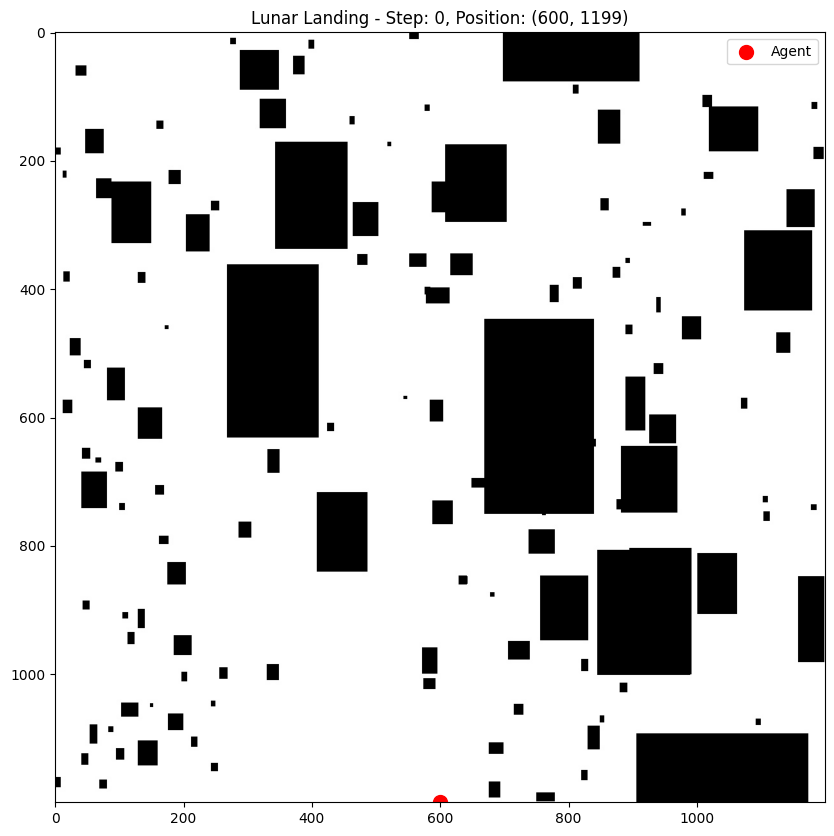



Initial Observation:
[[255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]]




In [ ]:
# Reset environment
observation, _ = env.reset()
env.render()
print("\n")
print("Initial Observation:")
print(observation)
print("\n")

Step 1:
Action Taken: 1
New Position: (600, 1199)
Reward: 1.8988205057861776
Done: False
Observation:


[[255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]]


Step 2:
Action Taken: 1
New Position: (600, 1199)
Reward: 1.8988205057861776
Done: False
Observation:


[[255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]]


Step 3:
Action Taken: 1
New Position: (600, 1199)
Reward: 1.8988205057861776
Done: False
Observation:


[[255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]]


Step 4:
Action Taken: 1
New Position: (600, 1199)
Reward: 1.8988205057861776
Done: False
Observation:


[[255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]]


Step 5:
Action Taken: 1
New Position: (600, 1199)
Reward: 1.8988205057861776
Done: False
Observation:


[[255 25

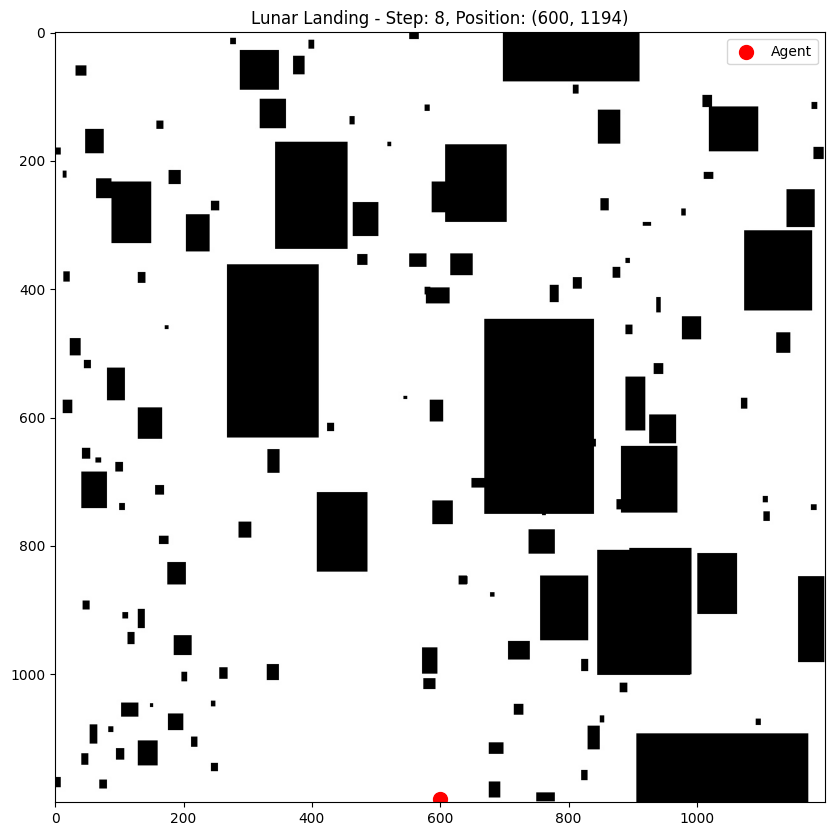

In [ ]:
# Take a few random steps and render
for i in range(10):
    action = env.action_space.sample()  # Random action (0: Up, 1: Down, 2: Left, 3: Right)
    obs, reward, done, _, _ = env.step(action)  # SB3 requires 5 outputs

    print(f"Step {i+1}:")
    print("Action Taken:", action)
    print("New Position:", env.current_position)
    print("Reward:", reward)
    print("Done:", done)
    print("Observation:")
    print("\n")
    print(obs)
    print("\n")

    if done:
        print("Episode ended.")
        break

# Visualize
env.render()

## Training RL Model

In [7]:
# Create Custom Environment
env = LunarLandingEnv(image_path)

# Wrap it for Stable-Baselines3
vec_env = make_vec_env(lambda: env, n_envs=1)

# Initialize PPO model
model = PPO("MlpPolicy", vec_env, verbose=1)

Using cpu device


In [ ]:
# Train the model
model.learn(total_timesteps=50000)  # Adjust timesteps as needed

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.14     |
|    ep_rew_mean     | 27.9     |
| time/              |          |
|    fps             | 0        |
|    iterations      | 1        |
|    time_elapsed    | 2971     |
|    total_timesteps | 2048     |
---------------------------------


In [ ]:
# Visualize
env.render()

## Save RL Model

In [ ]:
model.save("/content/drive/My Drive/ppo_lunar_landing")

## Evaluate RL Model

In [9]:
model = PPO.load("/content/drive/My Drive/ppo_lunar_landing", env= vec_env)

In [10]:
mean_reward, std_reward = evaluate_policy(model, vec_env, n_eval_episodes=10)
print(f"Mean Reward: {mean_reward}, Std Reward: {std_reward}")

Mean Reward: 213.96658699999998, Std Reward: 2.842170943040401e-14


## Load Trained RL Model

In [ ]:
del model

In [ ]:
model = PPO.load("/content/drive/My Drive/ppo_lunar_landing", env= vec_env)

## Test RL Model

In [ ]:
obs, _ = env.reset()
for _ in range(1000):  # Run for 1000 steps
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)
    if done:
        obs, _ = env.reset()

In [ ]:
# Visualize
env.render()

## Close the Environment

In [ ]:
env.close()